In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import cross_val_predict, cross_val_score, \
    GridSearchCV, RandomizedSearchCV, train_test_split, KFold, validation_curve

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import sys
from os import path
repository_path = path.expanduser('~')
sys.path.append(repository_path + '/modules')
from import_credentials import import_credentials
credentials = import_credentials()
conn_analytics = credentials['conn_analytics']
conn_pulse = credentials['pulse_athena']

## Reading data

In [3]:
data = pd.read_sql("""
select 
    ad_id, cars_brand, cars_model, cars_type, cars_engine, cars_gearbox, 
    cars_capacity, regdate, mileage, currency, price
from public.ad_params_auto a
left join public.alesha using (ad_id)
where 
    cars_brand is not null
    and publish_datetime >= '2020-01-01 00:00:00'  
    and regdate >= '2002'
limit 10000
""", conn_analytics)

ads = pd.read_sql("""
select ad_id, active_ads_of_user
from public.alesha a
where publish_datetime >= '2020-01-01 00:00:00'
""", conn_analytics)

### Merge data

In [4]:
data = data.merge(ads, on=['ad_id'], how='left')
data.head(4)

,ad_id,cars_brand,cars_model,cars_type,cars_engine,cars_gearbox,cars_capacity,regdate,mileage,currency,price,active_ads_of_user
0,92634787,Seat,Ibiza,hatchback,petrol,mechanics,1.2,2008,200000.0,BYR,10000.0,NaN
1,92627447,Acura,MDX,minivan,gasoline,automatic,1.7,2010,9364.0,BYR,NaN,1.0
2,92627980,Volkswagen,Polo,hatchback,diesel,mechanics,1.4,2008,121500.0,BYR,16000.0,NaN
3,92628231,Peugeot,207,hatchback,petrol,mechanics,1.4,2008,132000.0,BYR,9045.0,NaN


### Clear missed values

In [5]:
def missed(data, h = 10):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print('Missing values:')
    print(missing_data.head(h))
    
missed(data, 5)

Missing values:
                    Total  Percent
active_ads_of_user   3806   0.3806
price                 186   0.0186
cars_model            155   0.0155
cars_capacity          50   0.0050
cars_engine            12   0.0012


In [6]:
def missing_values_clean(data):
    data.active_ads_of_user = data.active_ads_of_user.fillna(0)
    data = data.dropna()
    return data

data = missing_values_clean(data)
missed(data, 5)

Missing values:
                    Total  Percent
active_ads_of_user      0      0.0
price                   0      0.0
currency                0      0.0
mileage                 0      0.0
regdate                 0      0.0


## Feature selecting and correlations (See EDA.jpnb)

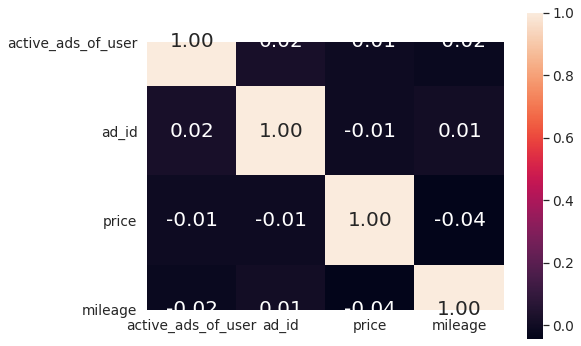

In [7]:
def targer_value_corr(data, target, k = 10, figsize = (10,10)):
    corrmatrix = data.corr()
    cols = corrmatrix.nlargest(k, target)[target].index
    cm = np.corrcoef(data[cols].values.T)
    plt.figure(figsize = figsize)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 20}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()
    
targer_value_corr(data, 'active_ads_of_user', figsize = (8,6))

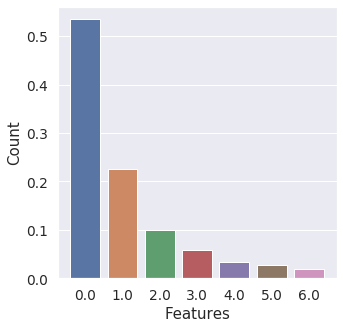

In [8]:
def value_counts_plot(variable):
    variable_counts = variable.value_counts(normalize=True)
    #print(variable_counts)
    f, ax = plt.subplots(figsize=(5, 5))
    sns.barplot(x=variable_counts.index, y=variable_counts)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Count', fontsize=15)
    plt.plot()
    
value_counts_plot(data.active_ads_of_user[data.active_ads_of_user < 7])

In [9]:
def feature_transforn_and_selection(data):
    data = data.replace({"cars_capacity" : '<1'}, 0)
    data = data.replace({"cars_capacity" : '>4'}, 5)
    data = data.replace({"regdate" : 'LTE1980'}, '1980')   
    data[['regdate','cars_capacity']] = data[['regdate','cars_capacity']].astype('float64')

    data = data[data.cars_engine.isin(['petrol', 'diesel'])]
    data = data[data.mileage >= 50] 
    #data.loc[data.currency == 'EUR', 'price'] *= data.value
    
    data = data[['cars_type', 'cars_engine','cars_gearbox', 
                 'cars_capacity' ,'regdate','mileage', 'price']]
    data = data.reset_index(drop = True)
    return data

data = feature_transforn_and_selection(data)
data.head()

,cars_type,cars_engine,cars_gearbox,cars_capacity,regdate,mileage,price
0,hatchback,petrol,mechanics,1.2,2008.0,200000.0,10000.0
1,hatchback,diesel,mechanics,1.4,2008.0,121500.0,16000.0
2,hatchback,petrol,mechanics,1.4,2008.0,132000.0,9045.0
3,sedan,diesel,mechanics,2.2,2003.0,450000.0,14756.0
4,off-road,diesel,mechanics,2.8,2008.0,180000.0,5859.0


## Dummies

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9343 entries, 0 to 9342
Data columns (total 7 columns):
cars_type        9343 non-null object
cars_engine      9343 non-null object
cars_gearbox     9343 non-null object
cars_capacity    9343 non-null float64
regdate          9343 non-null float64
mileage          9343 non-null float64
price            9343 non-null float64
dtypes: float64(4), object(3)
memory usage: 511.1+ KB


In [11]:
def dummy_encode(sample):
    cars_type_categories = ['sedan', 'minivan', 'off-road', 'hatchback', 'estate', 
                        'minibus', 'coupe', 'convertible', 'van', 'pickup']
    cars_gearbox_categories = ['automatic', 'mechanics']
    cars_engine_categories = ['petrol', 'diesel']

    sample.cars_type = pd.Categorical(sample.cars_type, categories = cars_type_categories)
    sample.cars_gearbox = pd.Categorical(sample.cars_gearbox, categories = cars_gearbox_categories)
    sample.cars_engine = pd.Categorical(sample.cars_engine, categories = cars_engine_categories)

    sample = pd.get_dummies(sample)
    return sample

data = dummy_encode(data)
data.head(4)

,cars_capacity,regdate,mileage,price,cars_type_sedan,cars_type_minivan,cars_type_off-road,cars_type_hatchback,cars_type_estate,cars_type_minibus,cars_type_coupe,cars_type_convertible,cars_type_van,cars_type_pickup,cars_engine_petrol,cars_engine_diesel,cars_gearbox_automatic,cars_gearbox_mechanics
0,1.2,2008.0,200000.0,10000.0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
1,1.4,2008.0,121500.0,16000.0,0,0,0,1,0,0,0,0,0,0,0,1,0,1
2,1.4,2008.0,132000.0,9045.0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
3,2.2,2003.0,450000.0,14756.0,1,0,0,0,0,0,0,0,0,0,0,1,0,1


# XGBoost

## simple fit-predict

In [12]:
X = data.drop(['price'], axis = 1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle = True)

In [14]:
params = {
    "objective": "binary:logistic",
    "max_depth":10,
    "learning_rate": 0.1,
    "colsample_bytree": 0.8,
    "subsample": 0.9,
    'min_child_weight': 4,
    "grow_policy": "lossguide",
    "tree_method": "hist",
    "n_estimators": 1000
}
xgb_model = xgb.XGBRegressor(**params, seed = 100)
xgb_model.fit(X_train, y_train)
pred = xgb_model.predict(X_test)

# predictions
print(pred[:5]//1, '\n', y_test.values[:5]//1)

[16000. 27296. 13631.  5323.  4412.] 
 [7.7990e+03 1.0999e+04 1.4000e+04 5.0000e+00 2.1000e+04]


## Find best params of XGBOOST

In [16]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': np.arange(2, 15, 1),
        'subsample': np.arange(0.1, 1, 0.01),
        'colsample_bytree': np.arange(0.1, 1, 0.01),
        'max_depth': np.arange(2, 6, 1)
        }

xgb_model = xgb.XGBRegressor(learning_rate=0.2, n_estimators=300, objective='reg:squarederror',
                    silent=True, nthread=1)

In [17]:
folds = 3
param_comb = 100

skf = KFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=param_comb, 
                                   scoring='neg_mean_absolute_error', n_jobs=4, 
                                   cv=skf.split(X,y), verbose=3, random_state=1001 )


In [18]:
# Here we go
import time
start_time = time.time() # timing starts from this point for "start_time" variable

random_search.fit(X, y)

print("---hist --- %s seconds ---" % (time.time() - start_time))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   44.4s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.9min finished
/home/arturyasnou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


---hist --- 113.31563830375671 seconds ---


In [19]:
print('\n Best estimator:')
print(random_search.best_estimator_)

print('\n Best hyperparameters:')
print(random_search.best_params_)

results = pd.DataFrame(random_search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)


 Best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.20999999999999996, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=2, min_child_weight=8, missing=None, n_estimators=300,
             n_jobs=1, nthread=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=0.9499999999999995, verbosity=1)

 Best hyperparameters:
{'subsample': 0.9499999999999995, 'min_child_weight': 8, 'max_depth': 2, 'colsample_bytree': 0.20999999999999996}


In [20]:
results[['rank_test_score', 'params']] #[results.rank_test_score == 1].params.values

,rank_test_score,params
1,1,"{'subsample': 0.9499999999999995, 'min_child_w..."
63,2,"{'subsample': 0.8999999999999996, 'min_child_w..."
87,3,"{'subsample': 0.9099999999999996, 'min_child_w..."
26,4,"{'subsample': 0.7499999999999997, 'min_child_w..."
52,5,"{'subsample': 0.7199999999999996, 'min_child_w..."
...,...,...
16,96,"{'subsample': 0.32999999999999985, 'min_child_..."
71,97,"{'subsample': 0.19999999999999996, 'min_child_..."
10,98,"{'subsample': 0.21999999999999995, 'min_child_..."
86,99,"{'subsample': 0.13999999999999999, 'min_child_..."


### Подберем оптимальное число деревьев. Зафиксируем lr и остальные параметры

In [22]:
params = {'subsample': 0.75, 
          'min_child_weight': 5,
          'max_depth': 4,
          'colsample_bytree': 0.75}

cv = KFold(n_splits=3, shuffle=True, random_state=43)

n_estimators_range = [30, 50, 100, 200, 300, 500, 750, 1000, 1500]

train_scores, test_scores = validation_curve(
    xgb.XGBRegressor(**params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv.split(X, y),
    scoring = 'explained_variance',
    n_jobs=3
)

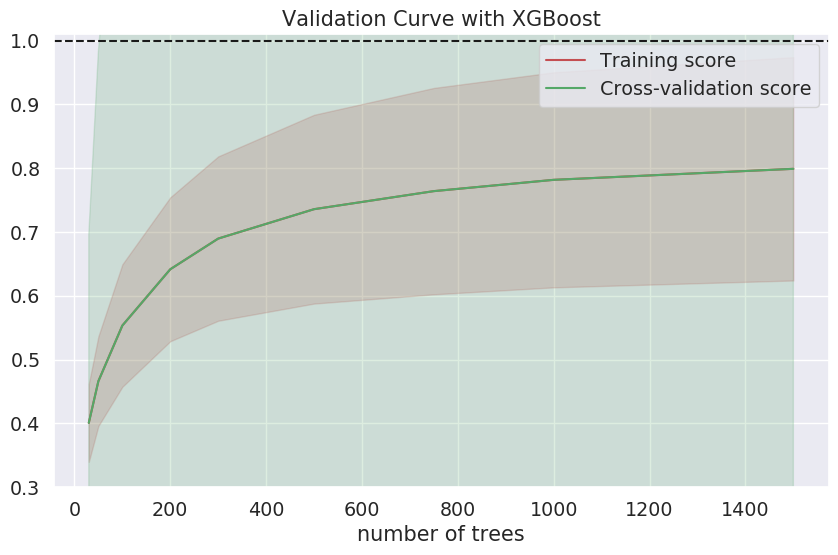

Best cross-validation result (0.799) obtained for 1500 trees


In [23]:
def plot_curve(train_scores, test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(train_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    fig = plt.figure(figsize=(10, 6), dpi=100)

    plt.title("Validation Curve with XGBoost")
    plt.xlabel("number of trees")
    #plt.ylabel("Accuracy")
    plt.ylim(0.3, 1.01)

    plt.plot(n_estimators_range,
                 train_scores_mean,
                 label="Training score",
                 color="r")

    plt.plot(n_estimators_range,
                 test_scores_mean, 
                 label="Cross-validation score",
                 color="g")

    plt.fill_between(n_estimators_range, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.2, color="r")

    plt.fill_between(n_estimators_range,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.2, color="g")

    plt.axhline(y=1, color='k', ls='dashed')

    plt.legend(loc="best")
    plt.show()

    i = np.argmax(test_scores_mean)
    print("Best cross-validation result ({0:.3f}) obtained for {1} trees".format(test_scores_mean[i], 
                                                                                 n_estimators_range[i]))
    
plot_curve(train_scores, test_scores)

### fit_predict + cross-validation   for final score

In [24]:
params = {
    "objective": "reg:squarederror",
    "max_depth":14,
    "learning_rate": 0.1,
    "colsample_bytree": 0.9,
    "subsample": 0.9,
    'min_child_weight': 4,
    "grow_policy": "lossguide",
    "tree_method": "hist",
    "n_estimators": 1000 #5000,
}
kfold = KFold(n_splits=10)
xgb_model = xgb.XGBRegressor(**params, seed = 100)
pred = cross_val_predict(xgb_model, X, y, cv=kfold)

# predictions
print(pred[:5]//1, '\n', y.values[:5])

[ 8179. 15991. 10334. 14439.  5910.] 
 [10000. 16000.  9045. 14756.  5859.]


In [25]:
pred.shape, y.shape

((9343,), (9343,))